In [2]:
#Liberías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve

from sklearn.metrics import accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer, MissingIndicator

from boruta import BorutaPy

In [3]:
# Yo cargaría el dataframe, para no repetir pasos
df = pd.read_parquet('../data/full_data_initial.parquet')

In [4]:
### HAY QUE MIRAR ESTO. SI LO HACEMOS, CAMBIA LA MORTALIDAD GENERAL DEL DATASET

#TODO:  ¿peatones (df['passenger_role'] == "99")?

# Remove non-driver rows

df = df.loc[(df['passenger_role'] == "11") | (df['passenger_role'] == "99")]

# Drop the role column

df = df.drop('passenger_role', axis = 1)
# por qué hacemos esto? por que el número de personas que van en un coche antes de un accidente no es una variable predecible
# y por lo tanto hemos de tener en cuenta únicamente al conductor, que en un caso hipotético de ponernos en el lugar de una
# empresa aseguradora, será el individuo sobre el cual tendremos información

# Además, nos evita problemas a la hora de entrenar los modelos ya que sería posible que varios registros del mismo coche,
# que inevitablemente tienen una correlación muy alta respecto de la variable objetivo, sesgando nuestros modelos.

In [5]:
#TODO: crear columna passenger count si es posible 
#Una forma sería unir tablas por el indice en df está intacto en df2 está reseteado
#Esto solo se podria hacer si partimos del mismo df guardado del descrptive
df2 = pd.read_parquet('../data/vehicle_data_initial.parquet')

### Valores Missing pt.1 (categóricas)

In [6]:
# Análisis Nulos
nulos_col = pd.merge(df.isnull().sum().sort_values().to_frame('missing_value').reset_index(),
         df.dtypes.to_frame('feature_type').reset_index(),
         on = 'index',
         how = 'inner')
nulos_col['columns_percentage'] = nulos_col['missing_value']/df.shape[0]
nulos_col.sort_values(['missing_value', 'feature_type', 'columns_percentage'], ascending=False)

,index,missing_value,feature_type,columns_percentage
17,vehicle_age,497550,float64,0.121817
16,passenger_safety,460486,object,0.112743
15,crash_place,345281,object,0.084537
14,road_slope,287521,object,0.070395
13,passenger_age,210849,float64,0.051623
12,traffic_state,157226,object,0.038494
11,passenger_sex,153774,float64,0.037649
10,crash_type,131908,object,0.032296
9,passenger_type,62699,object,0.015351
8,crash_weather,58033,object,0.014208


In [7]:
# Change nas for "NA" string in order to be able to encode it. (Maybe) we could've saved time earlier by not removing U,UU... but there still were NAs

na_cols = ["crash_type", "crash_place", "crash_weather", "surface_state", "road_slope", "traffic_state", "vehicle_type", "passenger_safety", "passenger_type"]

for col in na_cols:
    df[col].fillna("NA", inplace=True)

### Outliers

In [8]:
# Remove rows with an outlier vehicle_age
df = df.loc[(df['vehicle_age'] < 30) | (df['vehicle_age'].isnull())]

# Removes rows with outlier vehicles_involved
df = df.loc[(df['vehicles_involved'] < 6)  | (df['vehicles_involved'].isnull())]

### Tramificación Variable Temporales

In [9]:
#Transform month column to quarters
df['month'] = (df['month']-1)//3 + 1
df = df.rename({'month': 'quarter'}, axis= 1)

In [10]:
# Transform weekday column
df['weekday'] = df['weekday'].replace({6:3, 7:3, 1:2, 4:2, 5:2, 2:1, 3:1})

In [11]:
# Transform hour column
df['hour'] = df['hour'].replace({0:1, 1:1, 2:1, 3:1, 4:1, 5:1, 6:2, 7:2, 8:2, 9:3, 10:3, 11:3, 11:4, 12:4, 13:4, 14:4, 15:4, 16:4, 17:4, 18:4, 19:5, 20:5, 21:5, 22:6, 23:6})

### Train Test Split
Eliminar outliers y missings podemos hacerlo antes del split. Sin embargo, para imputar debemos hacerlo después con valores del Train

In [12]:
xtrain, xtest, ytrain, ytest = train_test_split(df.drop(columns=['fatality']), df['fatality'], test_size=0.25, random_state=0)
#xtrain = xtrain.drop(columns="index")
#xtest = xtest.drop(columns="index")

In [13]:
# Mean encoding
encode_cols = ["crash_type", "crash_place", "crash_weather", "surface_state", "road_slope", "traffic_state", "vehicle_type", "passenger_safety", "passenger_type"]

for i in encode_cols:
    encoder = TargetEncoder()
    encoder.fit(xtrain[i], ytrain)
    xtest[i] = encoder.transform(xtest[i])

for i in encode_cols:
    encoder = TargetEncoder()
    xtrain[i] = encoder.fit_transform(xtrain[i], ytrain)


C:\Users\Usuario\anaconda3\envs\core_models\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


### Encoding Variables categóricas

In [14]:
# One-hot-encoding
columnasfecha = ["hour", "weekday", "quarter", "passenger_sex"]

for i in columnasfecha:
    onehotencoder = OneHotEncoder(handle_unknown="ignore")
    array = xtrain[i].values.reshape(-1,1)
    df_temp = onehotencoder.fit_transform(array)
    colnames = onehotencoder.get_feature_names([i])
    df_temp = pd.DataFrame(df_temp.toarray(), columns = colnames)
    xtrain.index = df_temp.index
    xtrain = pd.concat([df_temp, xtrain], axis=1)
# We get rid of the not encoded columns
xtrain = xtrain.drop(columns = columnasfecha)
if "passenger_sex_nan" in xtrain.columns:
    xtrain = xtrain.drop(columns = "passenger_sex_nan")


# Same for xtest
for i in columnasfecha:
    onehotencoder = OneHotEncoder(handle_unknown="ignore")
    array = xtest[i].values.reshape(-1,1)
    df_temp = onehotencoder.fit_transform(array)
    colnames = onehotencoder.get_feature_names([i])
    df_temp = pd.DataFrame(df_temp.toarray(), columns = colnames)
    xtest.index = df_temp.index
    xtest = pd.concat([df_temp, xtest], axis=1)
xtest = xtest.drop(columns = columnasfecha)
if "passenger_sex_nan" in xtest.columns:
    xtest = xtest.drop(columns = "passenger_sex_nan")

C:\Users\Usuario\anaconda3\envs\core_models\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Usuario\anaconda3\envs\core_models\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Usuario\anaconda3\envs\core_models\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Usuario\anaconda3\envs\core_models\lib\site-packages\sklearn\utils\deprec

In [15]:
ytrain.index = xtrain.index
ytest.index = xtest.index

In [16]:
#Reordenamos columnas
new_cols = ['year','quarter_1','quarter_2','quarter_3','quarter_4','weekday_1','weekday_2','weekday_3','hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','vehicles_involved','crash_type','crash_place',
            'crash_weather','surface_state','road_slope','traffic_state','vehicle_type','vehicle_age','passenger_age','passenger_sex_0.0','passenger_sex_1.0','passenger_safety','passenger_type']


xtrain = xtrain.reindex(columns=new_cols)
xtest = xtest.reindex(columns=new_cols)

#### Comprobamos que Test y Train son similares

In [17]:
#Train
pd.concat([xtrain, pd.DataFrame(ytrain)]).describe()

,year,quarter_1,quarter_2,quarter_3,quarter_4,weekday_1,weekday_2,weekday_3,hour_1,hour_2,...,road_slope,traffic_state,vehicle_type,vehicle_age,passenger_age,passenger_sex_0.0,passenger_sex_1.0,passenger_safety,passenger_type,fatality
count,3.038164e+06,3.038164e+06,3.038164e+06,3.038164e+06,3.038164e+06,3.038164e+06,3.038164e+06,3.038164e+06,3.038164e+06,3.038164e+06,...,3.038164e+06,3.038164e+06,3.038164e+06,2.666075e+06,2.882144e+06,3.038164e+06,3.038164e+06,3.038164e+06,3.038164e+06,3.038164e+06
mean,2.006013e+03,2.308167e-01,2.362042e-01,2.672453e-01,2.657338e-01,2.954765e-01,4.648600e-01,2.396635e-01,6.235575e-02,1.178356e-01,...,1.497286e-02,1.497286e-02,1.497286e-02,7.411906e+00,3.940350e+01,3.681480e-01,5.943491e-01,1.497286e-02,1.497286e-02,1.497286e-02
std,4.570581e+00,4.213554e-01,4.247491e-01,4.425215e-01,4.417233e-01,4.562567e-01,4.987637e-01,4.268782e-01,2.418006e-01,3.224135e-01,...,6.971054e-03,7.393777e-03,9.233389e-03,5.281624e+00,1.676746e+01,4.823019e-01,4.910176e-01,1.118598e-02,4.198815e-03,1.214441e-01
min,1.999000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,6.393337e-03,3.021148e-03,3.802281e-03,-2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.167004e-02,8.194427e-03,0.000000e+00
25%,2.002000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.255489e-02,5.111348e-03,1.199566e-02,3.000000e+00,2.500000e+01,0.000000e+00,0.000000e+00,1.167004e-02,1.386449e-02,0.000000e+00
50%,2.006000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.255489e-02,2.137271e-02,1.199566e-02,7.000000e+00,3.800000e+01,0.000000e+00,1.000000e+00,1.167004e-02,1.386449e-02,0.000000e+00
75%,2.010000e+03,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.255489e-02,2.137271e-02,1.199566e-02,1.100000e+01,5.100000e+01,1.000000e+00,1.000000e+00,1.314618e-02,1.386449e-02,0.000000e+00
max,2.014000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,3.631339e-02,7.173913e-02,7.412399e-02,2.900000e+01,9.900000e+01,1.000000e+00,1.000000e+00,7.762971e-02,2.884398e-02,1.000000e+00


In [18]:
#Test
pd.concat([xtest, pd.DataFrame(ytest)]).describe()

,year,quarter_1,quarter_2,quarter_3,quarter_4,weekday_1,weekday_2,weekday_3,hour_1,hour_2,...,road_slope,traffic_state,vehicle_type,vehicle_age,passenger_age,passenger_sex_0.0,passenger_sex_1.0,passenger_safety,passenger_type,fatality
count,1.012722e+06,1.012722e+06,1.012722e+06,1.012722e+06,1.012722e+06,1.012722e+06,1.012722e+06,1.012722e+06,1.012722e+06,1.012722e+06,...,1.012722e+06,1.012722e+06,1.012722e+06,888502.000000,960260.000000,1.012722e+06,1.012722e+06,1.012722e+06,1.012722e+06,1.012722e+06
mean,2.006020e+03,2.312688e-01,2.360677e-01,2.676213e-01,2.650421e-01,2.954681e-01,4.650003e-01,2.395317e-01,6.270724e-02,1.178932e-01,...,1.498069e-02,1.497503e-02,1.496218e-02,7.413978,39.403911,3.680240e-01,5.943477e-01,1.498536e-02,1.496846e-02,1.517593e-02
std,4.566355e+00,4.216441e-01,4.246645e-01,4.427193e-01,4.413559e-01,4.562531e-01,4.987738e-01,4.267979e-01,2.424358e-01,3.224817e-01,...,6.971551e-03,7.385054e-03,9.211805e-03,5.282049,16.771328,4.822681e-01,4.910181e-01,1.123506e-02,4.191444e-03,1.222524e-01
min,1.999000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,6.393337e-03,3.021148e-03,3.802281e-03,-2.000000,1.000000,0.000000e+00,0.000000e+00,1.167004e-02,8.194427e-03,0.000000e+00
25%,2.002000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.255489e-02,5.111348e-03,1.199566e-02,3.000000,25.000000,0.000000e+00,0.000000e+00,1.167004e-02,1.386449e-02,0.000000e+00
50%,2.006000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.255489e-02,2.137271e-02,1.199566e-02,7.000000,38.000000,0.000000e+00,1.000000e+00,1.167004e-02,1.386449e-02,0.000000e+00
75%,2.010000e+03,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.255489e-02,2.137271e-02,1.199566e-02,11.000000,51.000000,1.000000e+00,1.000000e+00,1.314618e-02,1.386449e-02,0.000000e+00
max,2.014000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,3.631339e-02,7.173913e-02,7.412399e-02,29.000000,99.000000,1.000000e+00,1.000000e+00,7.762971e-02,2.884398e-02,1.000000e+00


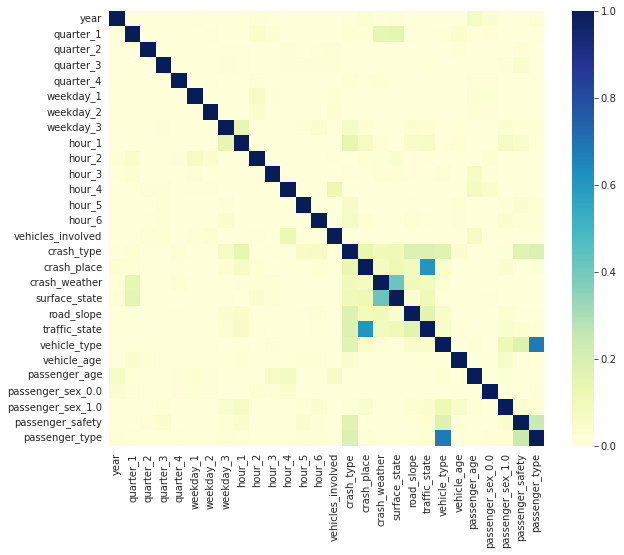

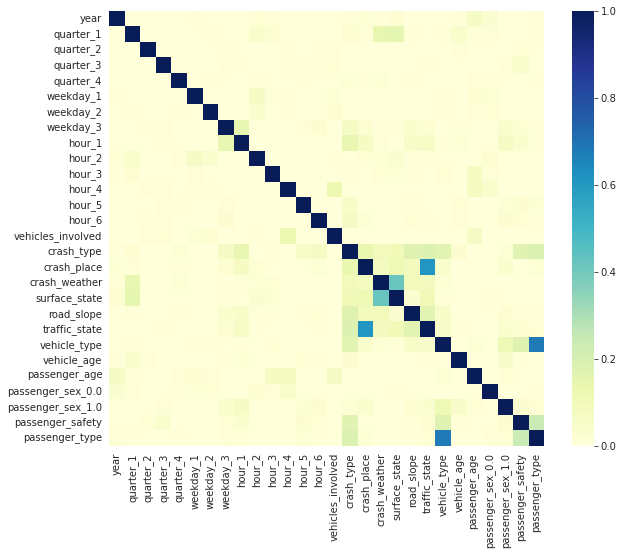

In [19]:
#Correlación de Spearman con todas las variables
plt.figure(figsize=(10,8))
with sns.axes_style("white"):
  ax = sns.heatmap(xtrain.corr('spearman'),vmin=0., vmax=1, square=True, cmap="YlGnBu")
plt.show()

plt.figure(figsize=(10,8))
with sns.axes_style("white"):
  ax = sns.heatmap(xtest.corr('spearman'),vmin=0., vmax=1, square=True, cmap="YlGnBu")
plt.show()

### Valores Missing pt.2 (Númericas)

In [20]:
# Análisis Nulos
nulos_col = pd.merge(xtrain.isnull().sum().sort_values().to_frame('missing_value').reset_index(),
         xtrain.dtypes.to_frame('feature_type').reset_index(),
         on = 'index',
         how = 'inner')
nulos_col['columns_percentage'] = nulos_col['missing_value']/xtrain.shape[0]
nulos_col.sort_values(['missing_value', 'feature_type', 'columns_percentage'], ascending=False)

,index,missing_value,feature_type,columns_percentage
27,vehicle_age,372089,float64,0.122472
26,passenger_age,156020,float64,0.051353
25,vehicles_involved,208,float64,0.000068
1,passenger_sex_1.0,0,float64,0.000000
2,passenger_sex_0.0,0,float64,0.000000
3,vehicle_type,0,float64,0.000000
4,traffic_state,0,float64,0.000000
5,road_slope,0,float64,0.000000
6,surface_state,0,float64,0.000000
7,crash_weather,0,float64,0.000000


La variable vehicles_involved apenas tiene nulos por lo que vamos a eliminar los registros. Para passenger_age y vehicle_age vamos a ver de nuevo como se distribuyen ambas variables y tomaremos una decisión sobre como imputar los valores nulos

#### Gráfico distribución de las variables

<AxesSubplot:xlabel='passenger_age'>

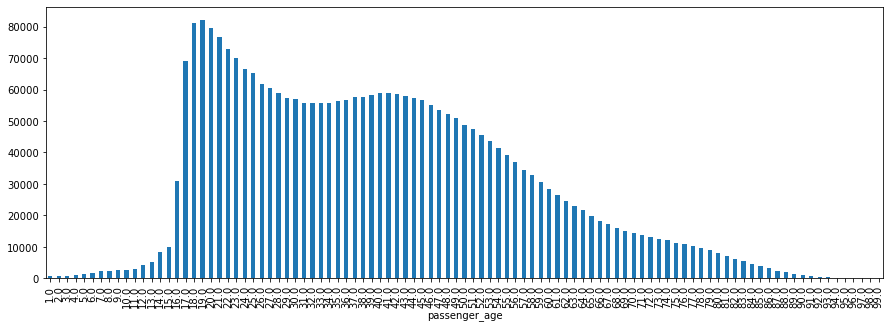

In [21]:
#passenger_age plot
plt.figure(figsize=(15,5))
pd.concat([xtrain, pd.DataFrame(ytrain)], axis=1).groupby(('passenger_age'))['fatality'].count().plot(kind="bar")

Encontramos algo curioso que no habíamos podido ver en el análisis descriptivo ya que vimos la distribución de edad con todos los pasajeros. Existen registros de conductores con una edad muy corta. ¡Tres, cuatro o cinco años! Outliers claramente erróneos que no deberíamos tener en cuenta. Acudiendo a la fuente oficial de los datos hemos encontrado la siguiente respuesta a la consulta de un usuario que confirma nuestras sospechas:  
*"The data in the NCDB are as reported by the provinces and territories. In some instances a child can be coded as being the driver when they are sitting on the lap of the real driver. In other cases, this would be an error, but there would be no way to determine which cases are the latter"* https://open.canada.ca/data/en/dataset/1eb9eba7-71d1-4b30-9fb1-30cbdab7e63a  
Con estos valores seguiremos la misma estrategia de imputación que empleemos con los missings

In [22]:
#Imputaremos los NAs un  valor fijo en base a un estadístico de su distribución 
print("La Media es",xtrain['passenger_age'].mean())
print("La Mediana es", xtrain['passenger_age'].median())
print("La Moda es",xtrain['passenger_age'].mode().values)

La Media es 39.4035044744468
La Mediana es 38.0
La Moda es [19.]


<AxesSubplot:xlabel='vehicle_age'>

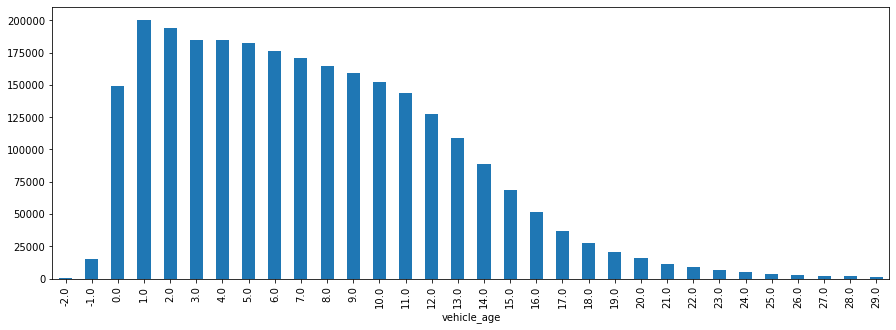

In [23]:
#vehicle_age plot
plt.figure(figsize=(15,5))
pd.concat([xtrain, pd.DataFrame(ytrain)], axis=1).groupby(('vehicle_age'))['fatality'].count().plot(kind="bar")

In [24]:
#Imputaremos los NAs un  valor fijo en base a un estadístico de su distribución 
print("La Media es",xtrain['vehicle_age'].mean())
print("La Mediana es", xtrain['vehicle_age'].median())
print("La Moda es",xtrain['vehicle_age'].mode())

La Media es 7.411905891619703
La Mediana es 7.0
La Moda es 0    1.0
dtype: float64


In [28]:
simp = SimpleImputer(missing_values=np.nan, strategy='median')
simp.fit(xtrain['vehicle_age'].reshape(-1,1))
#simp.transform(xtest['vehicle_age'])
simp.transform(xtrain['vehicle_age'])


AttributeError: 'Series' object has no attribute 'reshape'

In [ ]:
# df['vehicle_age'] = df['vehicle_age'].replace({np.nan:xtrain['vehicle_age'].median()})

# Selección de Variables

In [ ]:
#Guardamos los datos, divididos en X, Y, Train, Test
xtrain.to_parquet("../data/xtrain.parquet")
xtest.to_parquet("../data/xtest.parquet")
pd.DataFrame(ytrain).to_parquet("../data/ytrain.parquet")
pd.DataFrame(ytest).to_parquet("../data/ytest.parquet")

In [ ]:
#Escalado de variables
scaler = StandardScaler()
model_scaled = scaler.fit(xtrain)
xtrain_scaled = pd.DataFrame(scaler.transform(xtrain), columns=xtrain.columns, index=xtrain.index)
xtest_scaled = pd.DataFrame(scaler.transform(xtest), columns=xtest.columns, index=xtest.index)

# Quizás hacer el scaling solo en las columnas en las que hemos hecho el mean encoding, y no en las numéricas. Eso si al final lo utilizamos.

### Regulariación  Ridge


In [ ]:
sel_ridge = SelectFromModel(LogisticRegression(C=1, penalty='l2'), threshold = 0.02)
sel_ridge.fit(xtrain_scaled, ytrain)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': xtrain_scaled.columns,
                         'coef': sel_ridge.estimator_.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(16, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo ridge');

AttributeError: 'LogisticRegression' object has no attribute 'coef_'

### Algún otro método de slección de variables para comporbar

### Boruta

In [ ]:
# sampling in proportion to y labels
rf = RandomForestClassifier(n_jobs=-1, max_depth=4) # cambiar los hiperparametros

# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=0)

# find all relevant features - 5 features should be selected
feat_selector.fit(xtrain.values, ytrain) # Importante poner el .values al dataframe, sino dará error

# check selected features - first 5 features are selected
feat_selector.support_

# check ranking of features
feat_selector.ranking_

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0


KeyboardInterrupt: 

In [ ]:
#x